# Один заказ - два или три товара

In [119]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns

import catboost
from tqdm.notebook import tqdm

import warnings

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(10,6)}, style="darkgrid")
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

Чтение данных

In [120]:
data = pd.read_csv('data/data.csv', index_col=0)\
        .drop(['whs', 'selected_carton', 'sel_calc_cube', 'recommended_carton',
              'pack_volume', 'rec_calc_cube', 'who', 'trackingid', 'recommended_cartontype'], axis=1)
cargotype = pd.read_csv('data/cargotype_sort.csv', index_col=0)
sku_cargotypes = pd.read_csv('data/sku_cargotypes_filtered.csv')#только sku которые есть в data
sku = pd.read_csv('data/sku_filtered.csv')#только sku которые есть в data
sku['sku_vol'] = sku['a'] * sku['b'] * sku['c']

Как было выяснено в исследовательском анализе данных, у нас больше 20% заказов состоящие из 2-3 товаров. Для таких заказов построим отдельную модель классификации. 

In [121]:
round(data.groupby('orderkey')['sku'].count().value_counts(normalize=True)
            .head(10).reset_index().rename({'index':'goods_amount',
                                           'sku': 'share'}, axis=1),3)

,goods_amount,share
0,1,0.650
1,2,0.167
2,3,0.065
3,4,0.040
4,5,0.024
5,6,0.016
6,7,0.008
7,8,0.006
8,10,0.006
9,9,0.004


Отберем нужные заказы

In [122]:
# заказы с несколькими товарами(2-3)
orders_few_items = data.groupby('orderkey')['sku'].count()\
                .reset_index().query('sku!=1 & sku <4')['orderkey'].to_list()

# заказы где box_num имеет только одно уникальное значение
orders_one_box = data.groupby('orderkey')['box_num'].nunique()\
                .reset_index().query('box_num==1')['orderkey'].to_list()

len(orders_few_items), len(orders_one_box), data.orderkey.nunique()

(37083, 153355, 159899)

In [123]:
#заказы где несколько товаров но все в одной коробке
data_few_goods = data[(data.orderkey.isin(orders_few_items))&(data.orderkey.isin(orders_one_box))]

#есть несколько заказов(всего 736 строк) где box_num не 1, отбросим их, скорее всего какая-то ошибка выгрузки 
data_few_goods = data_few_goods[data_few_goods.box_num == 1]

Добавим размеры товаров и число товаров в заказе

In [124]:
data_few_goods = data_few_goods.merge(sku, on='sku', how='left').dropna()
data_few_goods = data_few_goods.merge(
    data_few_goods.groupby('orderkey')['sku']\
    .count().reset_index().rename({'sku':'sku_count'}, axis=1),
    on='orderkey', how='left'
    )

In [125]:
data_few_goods.head()

,orderkey,selected_cartontype,box_num,goods_wght,sku,a,b,c,sku_vol,sku_count
0,697bc0759d93e89ca047e59b8b7459dd,YME,1,0.271,45a12fc8954297bebfea4c8ac34a5f67,15.2,4.6,9.1,636.272,3
1,697bc0759d93e89ca047e59b8b7459dd,YME,1,0.335,f019ec008b87ea304aba9d081281d93b,24.8,3.6,37.7,3365.856,3
2,8c5b42304846e8b9cd90ea9e90e8e739,YME,1,0.300,de5fe5c43c07d5f39c3a92ac8fc43f51,20.0,10.0,20.0,4000.000,2
3,8c5b42304846e8b9cd90ea9e90e8e739,YME,1,0.710,fc91f8fe3ebb528f4a47512e6547bf61,42.0,9.0,31.0,11718.000,2
4,5ad381fd4097972e3b2ca9edfc51f6ac,YML,1,0.400,4128e7daa8fbe08603251c658aa19c02,25.0,23.0,34.0,19550.000,2


In [9]:
data_two = (data_few_goods[data_few_goods.sku_count==2]
            .drop(['sku_count', 'box_num'], axis=1).copy())

data_three = (data_few_goods[data_few_goods.sku_count==3]
            .drop(['sku_count', 'box_num'], axis=1).copy())

print(f'Two goods: {data_two.orderkey.nunique()}, three goods: {data_three.orderkey.nunique()}')

Two goods: 23263, three goods: 8985


Количество заказов по количествую уникальных sku в них

In [10]:
data_two.groupby('orderkey')['sku'].nunique().value_counts()

2    12919
1    10344
Name: sku, dtype: int64

In [11]:
data_three.groupby('orderkey')['sku'].nunique().value_counts()

3    3823
1    2758
2    2404
Name: sku, dtype: int64

### Два товара в заказе

Для создания матрицы признаков на которой будут обучаться модели, преобразуем данные о товаарх в заказе из длинного в широкий формат. При этом будем сортировать товары по объему и для каждого товара отсортируем его линейные размеры. 

In [12]:
#все заказы будут лежать в этом списке
dt = []

for order in tqdm(data_two.orderkey.unique()): #беру каждый заказ
    order_features = [order] #закидываю в пустой список ключ заказа
    t = data_two[data_two.orderkey==order] #это датафрейм с этим заказом
    for _, sku in t.sort_values(by='sku_vol').iterrows(): #пробегаюсь по каждой строке отсортированнного датайрейма
        sku = sku.to_dict()
        dims = sorted([sku['a'],sku['b'],sku['c']], reverse=True)
        order_features+= [sku['goods_wght'], # и закидываю фичи
                          dims[0],
                          dims[1],
                          dims[2],
                          sku['sku_vol']]
    order_features.append(t.selected_cartontype.unique()[0])#в конце закидываю упаковку которую выбрал упаковщик
    dt.append(order_features)

  0%|          | 0/23263 [00:00<?, ?it/s]

In [13]:
#все закидываю в датафрейм, колонки соответственно по порядку
df_features = pd.DataFrame(dt, columns=[
    'orderkey', 
    'wght1', 'a1','b1','c1', 'sku_vol1', 
    'wght2', 'a2','b2','c2', 'sku_vol2',
    'selected_cartontype'
])
# доп фичи - общий объем и вес, минимальные и максимальные размеры из обоих товаров
df_features['total_vol'] = df_features['sku_vol1'] + df_features['sku_vol2']
df_features['total_wght'] = df_features['wght1'] + df_features['wght2']
df_features['min_dim'] = df_features[['a1','b1', 'c1','a2','b2','c2']].min(axis=1)
df_features['max_dim'] = df_features[['a1','b1', 'c1','a2','b2','c2']].max(axis=1)
df_features.head()

,orderkey,wght1,a1,b1,c1,sku_vol1,wght2,a2,b2,c2,sku_vol2,selected_cartontype,total_vol,total_wght,min_dim,max_dim
0,8c5b42304846e8b9cd90ea9e90e8e739,0.300,20.0,20.0,10.0,4000.00,0.71,42.0,31.0,9.0,11718.0,YME,15718.00,1.010,9.0,42.0
1,5ad381fd4097972e3b2ca9edfc51f6ac,0.400,34.0,25.0,23.0,19550.00,0.40,34.0,25.0,23.0,19550.0,YML,39100.00,0.800,23.0,34.0
2,9995eab549a13749c96a4dcad23ea0c6,0.600,25.0,8.0,7.0,1400.00,0.60,25.0,8.0,7.0,1400.0,MYC,2800.00,1.200,7.0,25.0
3,a6484ed8f8afb062f95b504b694984e1,0.090,13.0,8.0,5.0,520.00,0.09,13.0,8.0,5.0,520.0,MYB,1040.00,0.180,5.0,13.0
4,622837253c2b6c80230502b4b3f3f670,0.851,24.0,16.1,5.8,2241.12,0.30,20.0,16.0,8.0,2560.0,MYD,4801.12,1.151,5.8,24.0


In [14]:
#дубликаты по заказам у которых отличается только orderkey
df_features.drop('orderkey', axis=1).duplicated().sum()

3029

In [15]:
# их точно убираем
df_features = df_features[~df_features.drop('orderkey', axis=1).duplicated()]

In [18]:
# дубликаты в заказах где все признаки одинаковые, но отличаются selected_cartontype
df_features = df_features[~df_features.drop(['orderkey', 'selected_cartontype'], 
                                           axis=1).duplicated(keep='first')]

Посмотрим выбросы по весу и объему

total weight 99 quantile: 6.46


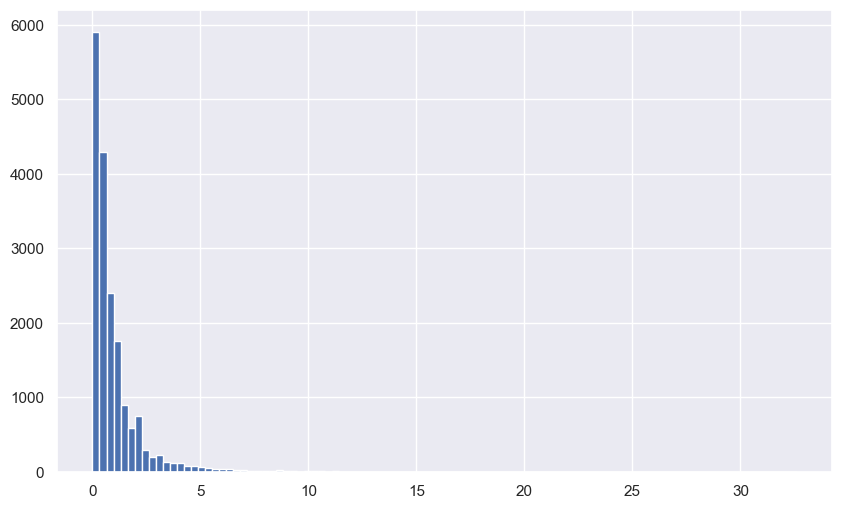

In [21]:
# вот тут возможно есть смысла почистить выбросы
df_features.total_wght.hist(bins=100);
total_wght_99q = df_features.total_wght.quantile(0.99)
print(f'total weight 99 quantile: {total_wght_99q:.2f}')

total volume 99 quantile: 27737.04


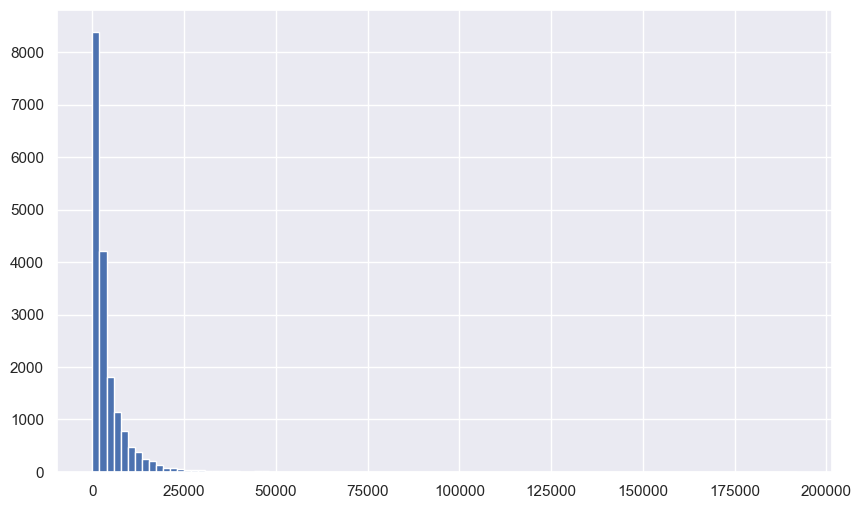

In [22]:
df_features.total_vol.hist(bins=100);
total_vol_99q = df_features.total_vol.quantile(0.99)
print(f'total volume 99 quantile: {total_vol_99q:.2f}')

In [23]:
df_features = df_features[(df_features.total_wght<total_wght_99q)&
                            (df_features.total_vol<total_vol_99q)]

In [24]:
X = df_features.drop(['orderkey', 'selected_cartontype'], axis=1).values

In [25]:
df_features.selected_cartontype.value_counts()

MYB        4567
MYC        4209
MYD        1842
YMC        1594
YMA        1567
MYA        1187
YMF         692
MYE         641
YMW         555
YMG         399
STRETCH     285
NONPACK     141
MYF         133
YME          59
YMX          15
YMB           1
Name: selected_cartontype, dtype: int64

Так как у нас много разных упаковок, есть смысл сначала определить относится ли упаковка к самым популярным, или же это "все остальные". Для разных порогов определения самых популярных упаковок, проверим как работает классификатор catboost

In [28]:
%%time
# определим отностится ли упаковка к одному из самых популярных типов упаковки
# смотрим от топ4 до топ 10
for i in tqdm(range(4,10)):
    # список с топ i самыми популярными упаковками
    most_pop_pack = df_features.selected_cartontype.value_counts().head(i).index

    #если не 
    #в списке, то 1, все остальные 0
    y = df_features.selected_cartontype.map(lambda x: 
                                           0 if x in most_pop_pack else 1).values

    cb = catboost.CatBoostClassifier(verbose=False)
    # порог принятия решения не определен и у нас очевидно сильный дисбалланс классов,
    # поэтому измеряем roc_auc
    cv_scores = cross_validate(cb, X, y, cv=5, n_jobs=-1,
                               scoring=['roc_auc'])
    print(f'top-{i}')
    print(f'classes balance: {np.mean(y):.2f}')
    print('roc auc:', np.mean(cv_scores['test_roc_auc']), '\n')

  0%|          | 0/6 [00:00<?, ?it/s]

top-4
classes balance: 0.32
roc auc: 0.7394885221361118 

top-5
classes balance: 0.23
roc auc: 0.8205550154997855 

top-6
classes balance: 0.16
roc auc: 0.8756205221066133 

top-7
classes balance: 0.12
roc auc: 0.8768420047447497 

top-8
classes balance: 0.09
roc auc: 0.8617476717194705 

top-9
classes balance: 0.06
roc auc: 0.8382395917203462 

CPU times: user 396 ms, sys: 166 ms, total: 562 ms
Wall time: 2min


Возьмем топ-6 самых часто встречающихся упаковок. 
Если классификатор считает что отдельно взятый заказ не подходит для упаковки в топ-6, определяем алгоритмически.
Если относит к топ-6, то для каждого типа упаковки сделаем отдельный бинарный классификатор. 

In [29]:
# возьму топ-6 классов
pack_list = list(df_features.selected_cartontype.value_counts().head(6).index)
rest_packs_two = [pack for pack in df_features.selected_cartontype.unique() if pack not in pack_list]
df_lim = df_features[df_features.selected_cartontype.isin(pack_list)].copy()
pack_dict = dict(zip(pack_list, range(len(pack_list))))

In [35]:
%%time
#готовая обученная модель
cb = catboost.CatBoostClassifier(verbose=False)
X = df_features.drop(['orderkey', 'selected_cartontype'], axis=1)
y = df_features.selected_cartontype.map(lambda x: 
                                0 if x in pack_list else 1).values
cb_two_class = cb.fit(X, y)

CPU times: user 23.4 s, sys: 1.02 s, total: 24.5 s
Wall time: 3.93 s


Теперь для каждой из упаковок в топ-6 обучим отдельный классификатор:

In [38]:
%%time

X = df_lim.drop(['orderkey', 'selected_cartontype'], axis=1).values
y = df_lim.selected_cartontype.map(pack_dict).values

roc_scores = []
for key in tqdm(pack_dict.keys()):
    y = df_lim.selected_cartontype.map(lambda x: 1 if x==key else 0).values
    class_w_dict = dict(zip([0,1], compute_class_weight(class_weight='balanced', classes=[0,1], y=y)))
    cb = catboost.CatBoostClassifier(verbose=False, class_weights = class_w_dict)
    cv_scores = cross_validate(cb, X, y, cv=5, n_jobs=-1,
                           scoring=[
                               'accuracy', 'recall', 'precision', 'f1', 'roc_auc'
                           ])
    roc_scores.append((key, round(np.mean(cv_scores['test_roc_auc']),2)))
    
roc_scores

  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: user 261 ms, sys: 130 ms, total: 391 ms
Wall time: 1min 53s


[('MYB', 0.79),
 ('MYC', 0.69),
 ('MYD', 0.87),
 ('YMC', 0.82),
 ('YMA', 0.76),
 ('MYA', 0.78)]

Нельзя говорить об очень высоком качестве моделей, полагаться только на их предсказания мы не будем. Как и в случае с одним товаром в заказе будем использовать комбинацию подходов. 

In [39]:
# обучаю каждую модель
cb_myb, cb_myc, cb_myd, cb_ymc, cb_yma, cb_mya = None,None,None,None,None,None
models = [cb_myb, cb_myc, cb_myd, cb_ymc, cb_yma, cb_mya]
packs = [pack[0] for pack in roc_scores]
models_list = [[p,m] for p,m in zip(packs, models)]

In [42]:
# обучение моделей
def train_models(models_list: list, 
                 X_train:np.array,
                 y_train:np.array)-> list:
    #для пары упаковка-модель делаю обучение
    for model in tqdm(models_list): 
        cb = catboost.CatBoostClassifier(verbose=False)
        y = np.array(list(map(lambda x: 1 if x==model[0] else 0, y_train)))
        cb.fit(X_train,y)
        model[1] = cb
        
    return models_list

In [43]:
models_list_two_goods = train_models(models_list, 
                                    X,df_lim.selected_cartontype.values)

  0%|          | 0/6 [00:00<?, ?it/s]

In [45]:
#все модели для двух товаров сохраним в файле two_goods_models.pkl
two_goods_models = ((cb_two_class, rest_packs_two), models_list_two_goods)


# with open('models/two_goods_models.pkl', 'wb') as handler:
#     pickle.dump(two_goods_models, handler)

In [47]:
#для проверки на выборке из n сэмплов
def make_test(models_list, X_test, y_test, n_samples=3_000, top_k=3) -> float:
    r = []
    for _ in tqdm(range(n_samples)):
        idx = np.random.randint(0,len(X_test))
        features, true_answer = X_test[idx], y_test[idx]

        result = []
        for model in models_list:
            result.append((model[0], model[1].predict_proba(features)[1]))

        top_3 = [x[0] for x in sorted(result, key=lambda x: x[1], reverse=True)[:top_k]]

        r.append(true_answer in top_3)

    return np.mean(r)

Протестируем работу моделей на 10 случайных сплитах. Будем брать топ 3 упаковок рекомендованных моделью и смотреть находится ли в них действительно использованная.

In [49]:
# тестирую на 10 разных сплитах
# по сути как кросс-валидация
res = []
for test in tqdm(range(10)):
    print(f'test #{test+1}')
    X_train, X_test, y_train, y_test = train_test_split(X, df_lim.selected_cartontype.values, 
                                                        test_size=0.2)
    #модели
    models_list = train_models(models_list_two_goods, X_train, y_train)
    test_res = make_test(models_list, X_test, y_test, top_k=3)
    res.append(test_res)
    print(test_res)


  0%|          | 0/10 [00:00<?, ?it/s]

test #1


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

0.877
test #2


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

0.872
test #3


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

0.8776666666666667
test #4


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

0.8766666666666667
test #5


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

0.887
test #6


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

0.8826666666666667
test #7


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

0.87
test #8


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

0.889
test #9


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

0.8856666666666667
test #10


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

0.8903333333333333


In [50]:
print(np.mean(res))

0.8808


То есть в 88% случаев у нас в топ-3 рекомендованных упаковок находится выбранная упаковщиком. 

### Three goods

In [51]:
dt = []

for order in tqdm(data_three.orderkey.unique()): #беру каждый заказ
    order_features = [order] #закидываю в пустой список ключ заказа
    t = data_three[data_three.orderkey==order] #это датафрейм с этим заказом
    for sku in t.sort_values(by='sku_vol').iterrows(): #пробегаюсь по каждой строке отсортированнного датайрейма
        dims = sorted([sku[1]['a'], sku[1]['b'], sku[1]['c']], reverse=True)
        order_features+= [sku[1]['goods_wght'], # и закидываю фичи
                          dims[0],
                          dims[1],
                          dims[2],
                          sku[1]['sku_vol']]
    order_features.append(t.selected_cartontype.unique()[0])#в конце закидываю упаковку которую выбрал упаковщик
    dt.append(order_features)


  0%|          | 0/8985 [00:00<?, ?it/s]

In [52]:

df_features = pd.DataFrame(dt, columns=[
    'orderkey', 
    'wght1', 'a1','b1','c1', 'sku_vol1', 
    'wght2', 'a2','b2','c2', 'sku_vol2',
    'wght3', 'a3','b3','c3', 'sku_vol3',
    'selected_cartontype'
])
# доп фичи - общий объем и вес, минимальные и максимальные размеры из обоих товаров
df_features['total_vol'] = df_features['sku_vol1'] + df_features['sku_vol2'] + df_features['sku_vol3']
df_features['total_wght'] = df_features['wght1'] + df_features['wght2'] + df_features['wght3']
df_features['min_dim'] = df_features[['a1','b1', 'c1','a2','b2','c2','a3','b3','c3']].min(axis=1)
df_features['max_dim'] = df_features[['a1','b1', 'c1','a2','b2','c2','a3','b3','c3']].max(axis=1)
df_features.head()

,orderkey,wght1,a1,b1,c1,sku_vol1,wght2,a2,b2,c2,sku_vol2,wght3,a3,b3,c3,sku_vol3,selected_cartontype,total_vol,total_wght,min_dim,max_dim
0,697bc0759d93e89ca047e59b8b7459dd,0.271,15.2,9.1,4.6,636.272,0.335,37.7,24.8,3.6,3365.856,0.948,37.9,32.3,26.2,32073.254,YME,36075.382,1.554,3.6,37.9
1,b1ac9fb03493100e5359a48738756bec,0.060,15.0,11.0,1.0,165.000,0.726,22.0,8.1,6.8,1211.760,0.726,22.0,8.1,6.8,1211.760,MYC,2588.520,1.512,1.0,22.0
2,78bd23955c39cca5dc292259f8ff2929,0.900,19.0,10.0,6.0,1140.000,0.801,16.6,9.8,8.2,1333.976,1.001,19.1,10.8,7.1,1464.588,YMC,3938.564,2.702,6.0,19.1
3,deac4cab8596937077633f93aa4f9fd1,0.340,15.0,10.0,7.0,1050.000,0.340,15.0,10.0,7.0,1050.000,0.340,15.0,10.0,7.0,1050.000,YMC,3150.000,1.020,7.0,15.0
4,597c6135d3761d3bf30df9c99ea96670,0.005,13.5,7.0,0.3,28.350,0.420,23.5,13.1,11.2,3447.920,0.420,23.5,13.1,11.2,3447.920,YMF,6924.190,0.845,0.3,23.5


In [53]:
#дубликаты по заказам у которых отличается только orderkey

df_features.drop('orderkey', axis=1).duplicated().sum()

494

In [54]:
df_features = df_features[~df_features.drop('orderkey', axis=1).duplicated()]

In [55]:
df_features = df_features[~df_features.drop(['orderkey', 'selected_cartontype'], 
                                            axis=1).duplicated(keep='first')]#.sum()
df_features.shape

(8085, 21)

Так же как и для двух товаров проверим как лучше отделить самые популярные и "все остальные"

In [56]:
%%time
# определим отностится ли упаковка к одному из самых популярных типов упаковки

X = df_features.drop(['orderkey', 'selected_cartontype'], axis=1).values

for i in tqdm(range(4,10)):
    # список с топ i самыми популярными упаковками
    most_pop_pack = df_features.selected_cartontype.value_counts().head(i).index

    #если в списке, то 1, все остальные 0
    y = df_features.selected_cartontype.map(lambda x: 
                                           0 if x in most_pop_pack else 1).values

    cb = catboost.CatBoostClassifier(verbose=False)
    # порог принятия решения не определен и у нас очевидно сильный дисбалланс классов,
    # поэтому измеряем roc_auc
    cv_scores = cross_validate(cb, X, y, cv=5, n_jobs=-1,
                               scoring=['roc_auc'])
    print(f'top-{i}')
    print(f'classes balance: {np.mean(y):.2f}')
    print('roc auc:', np.mean(cv_scores['test_roc_auc']), '\n')

  0%|          | 0/6 [00:00<?, ?it/s]

top-4
classes balance: 0.36
roc auc: 0.7610526592796777 

top-5
classes balance: 0.28
roc auc: 0.8535596140154376 

top-6
classes balance: 0.21
roc auc: 0.8498863242662456 

top-7
classes balance: 0.16
roc auc: 0.8153873465390739 

top-8
classes balance: 0.12
roc auc: 0.7584749932076691 

top-9
classes balance: 0.08
roc auc: 0.7653577767378099 

CPU times: user 338 ms, sys: 167 ms, total: 504 ms
Wall time: 1min 29s


В этом случае берем топ-5

In [61]:
pack_list = df_features.selected_cartontype.value_counts().head(5).index
rest_packs_three = [pack for pack in df_features.selected_cartontype.unique() if pack not in pack_list]
df_lim = df_features[df_features.selected_cartontype.isin(pack_list)].copy()
pack_dict = dict(zip(pack_list, range(len(pack_list))))

In [62]:
%%time
#готовая обученная модель
cb = catboost.CatBoostClassifier(verbose=False)
X = df_features.drop(['orderkey', 'selected_cartontype'], axis=1).values
y = df_features.selected_cartontype.map(lambda x: 
                                           0 if x in pack_list else 1).values
cb_three_class = cb.fit(X, y)


CPU times: user 16 s, sys: 1.7 s, total: 17.7 s
Wall time: 3.6 s


In [64]:
%%time
X = df_lim.drop(['orderkey', 'selected_cartontype'], axis=1).values
y = df_lim.selected_cartontype.map(pack_dict).values
roc_scores = []
for key in tqdm(pack_dict.keys()):
    y = df_lim.selected_cartontype.map(lambda x: 1 if x==key else 0).values
    class_w_dict = dict(zip([0,1], compute_class_weight(class_weight='balanced', classes=[0,1], y=y)))

    cb = catboost.CatBoostClassifier(verbose=False, class_weights = class_w_dict)
    cv_scores = cross_validate(cb, X, y, cv=5, n_jobs=-1,
                           scoring=['roc_auc'])
    roc_scores.append((key, np.mean(cv_scores['test_roc_auc'])))
    
roc_scores

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 289 ms, sys: 75.9 ms, total: 365 ms
Wall time: 1min 4s


[('MYC', 0.6445817574753506),
 ('MYB', 0.8117974372906234),
 ('YMC', 0.7936686152213026),
 ('MYD', 0.8386702648069523),
 ('YMA', 0.7359585563940807)]

In [65]:
# обучаю каждую модель
cb_myc, cb_myb, cb_ymc, cb_myd, cb_yma = None,None,None,None,None
models = [cb_myc, cb_myb, cb_ymc, cb_myd, cb_yma]
packs = [pack[0] for pack in roc_scores]
models_list = [[p,m] for p,m in zip(packs, models)]

In [67]:
#тестирую на 5 разных сплитах
# по сути как кросс-валидация
res = []
for test in tqdm(range(5)):
    print(f'test #{test+1}')
    X_train, X_test, y_train, y_test = train_test_split(X, df_lim.selected_cartontype.values, 
                                                        test_size=0.2)
    #модели
    models_list = train_models(models_list, X_train, y_train)
    # тут тоже берем топ-3
    test_res = make_test(models_list, X_test, y_test, top_k=3)
    res.append(test_res)
    print(test_res)

  0%|          | 0/5 [00:00<?, ?it/s]

test #1


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

0.9073333333333333
test #2


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

0.8946666666666667
test #3


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

0.8893333333333333
test #4


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

0.9056666666666666
test #5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

0.916


In [68]:
np.mean(res)

0.9026000000000002

В случае с 3 товарами даже немного чаще выбранная упаковка попадает в топ-3 рекомендованных моделью. 

In [132]:
models_list_three_goods = train_models(models_list, 
                                    X, df_lim.selected_cartontype.values)

  0%|          | 0/5 [00:00<?, ?it/s]

In [133]:
# модели для трех товаров будут лежать в файле three_goods_models.pkl
three_goods_models = ((cb_three_class, rest_packs_three), models_list_three_goods)

# with open('models/three_goods_models.pkl', 'wb') as handler:
#     pickle.dump(three_goods_models, handler)

### Тестирование рекомендаций с использованием алгоритмического подхода

In [73]:
order = data_few_goods.orderkey.sample(1).values[0]

In [79]:
data_few_goods[data_few_goods.orderkey==order]

,orderkey,selected_cartontype,box_num,goods_wght,sku,a,b,c,sku_vol,sku_count
55269,7baee4bcacc2220ba18c16073a8e4d8c,MYC,1,0.230,7ce612f57456c31f4575b9c71f498e45,11.0,5.0,28.0,1540.0,2
55358,7baee4bcacc2220ba18c16073a8e4d8c,MYC,1,0.224,45a58ffb509c2ae4ce9d68082df8bf79,6.0,18.0,4.0,432.0,2


In [92]:
# импортируем алгоритмический подбор и функцию подготовки фичей для заказов
from packer import get_packed
from utils import cook_features, get_cheapest

In [86]:
def get_json_sample(data: pd.DataFrame, order: str)-> dict:

    jsn = {'orderkey': order,
          'items': []}
    for i, sku in data[data.orderkey==order].iterrows():
        item = {}
        for param in ['sku', 'goods_wght', 'a','b','c']:
            item[param] = sku[param]
        item['count'] = 1
        item['cargotypes'] = ['0']
        jsn['items'].append(item)
    return jsn

In [128]:
def ml_two_three(query: dict, n_goods=2, top_k=3) -> list:
    """Get predictions for two or three goods in order
    using a combinations of several catboost classifiers
    pretrained for 2 and 3 (separately) goods in order.
    At the first step the classifier determines which group
    of packs is more appropriate. At the next step(if its the
    most common group) a few separated classifiers return their
    scores related to each package type. Then the top_k packages
    with the highest scores are picked.
    """
    features = cook_features(query)
    
    tools = three_goods_models if n_goods == 3 else two_goods_models

    cb, rest_packs = tools[0][0], tools[0][1]
    if cb.predict(features):
        return rest_packs

    multiclass_result = []
    for model in tools[1]:
        multiclass_result.append((model[0],
                                  model[1].predict_proba(features)[1]))

    result_packs = sorted(multiclass_result,
                          key=lambda x: x[1],
                          reverse=True)[:top_k]
    return [pack[0] for pack in result_packs]

In [108]:
def predict_two_three(query: dict, top_k: int = 3, n_goods: int = 2) -> str:
    """Recommend pack for two-three items
    Combination of ml predictions and algo sort
    """
    n_goods = len(query['items'])
    ml_preds = ml_two_three(query, n_goods)
    algo_preds = get_packed(query)[0]

    if len(ml_preds) > top_k:
        for pack in algo_preds:
            if pack in ml_preds:
                return pack

    ml_alg = set(ml_preds) & set(algo_preds[:3])

    return get_cheapest(ml_alg)

In [126]:
data = (pd.read_csv('data/data.csv', index_col=0)
        [['orderkey', 'recommended_cartontype']])
data_few_goods = data_few_goods.merge(data, on='orderkey', how='left')
prices = pd.read_csv('data/carton_price.csv')
prices_dict = dict(zip(prices.cartontype, 
                       prices.price))

In [134]:
pred_prices, rec_prices, sel_prices = [],[],[]
for _ in tqdm(range(10_000)):
    order_k = data_few_goods.orderkey.sample(1).values[0]
    jsn = get_json_sample(data_few_goods, order_k)
    # упаковка выбранная упаковщиком
    sel_cart = data_few_goods[data_few_goods.orderkey==order_k]['selected_cartontype'].values[0]
    sel_prices.append(prices_dict.get(sel_cart, 1))
    #упаковка рекомендованная текущей моделью
    rec_cart = data_few_goods[data_few_goods.orderkey==order_k]['recommended_cartontype'].values[0]
    rec_prices.append(prices_dict.get(rec_cart, 1))
    #упаковка рекомендованная новой моделью
    pred_cart = predict_two_three(jsn)
    pred_prices.append(prices_dict.get(pred_cart, 1))
    

  0%|          | 0/10000 [00:00<?, ?it/s]

In [135]:
# сравнение с рекомендованной упаковкой
round(mape(rec_prices, pred_prices),3)

0.596

In [136]:
# сравнение с выбранной упаковкой
round(mape(sel_prices, pred_prices),3)

0.724

Как и в случае с одним товаром в заказе удалось существенно снизить цену упаковки.